In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Loading and splitting data

In [3]:
train_data = pd.read_csv('proj3_cleaned_train_data.csv')
val_data = pd.read_csv('proj3_cleaned_validation_data.csv')
test_data = pd.read_csv('proj3_cleaned_test_data.csv')

In [4]:
X_train_processed = train_data.drop(train_data.columns[0], axis=1)
y_train = train_data[train_data.columns[0]]

X_val_processed = val_data.drop(val_data.columns[0], axis=1)
y_val = val_data[val_data.columns[0]]

X_test_processed = test_data.drop(test_data.columns[0], axis=1)
y_test = test_data[test_data.columns[0]]

# 1. Logistic Regression

In [7]:
best_c = 0
best_acc = 0
best_pen = None

penalties = ['l1', 'l2']
c_vals = [0.01,0.1,0.5,1,2,3]
solver = 'lbfgs'
for pen in penalties:
    if pen == 'l1':
        solver = 'liblinear'
    else:
        solver = 'lbfgs'
    for cval in c_vals:
        logclass = LogisticRegression(penalty = pen, C = cval, solver = solver, random_state = 12)
        logclass.fit(X_train_processed, y_train)
        log_pred = logclass.predict(X_val_processed)
        logacc = sum(y_val == log_pred)/len(y_val)
        if logacc > best_acc:
            best_c = cval
            best_acc = logacc
            best_pen = pen
        print(f"Penalty: {pen}, C value: {cval}, Accuracy: {logacc}")
print(f"Best Pen: {best_pen}, Best C value: {best_c}, Best Accuracy: {best_acc}")

Penalty: l1, C value: 0.01, Accuracy: 0.7603711790393013
Penalty: l1, C value: 0.1, Accuracy: 0.770414847161572
Penalty: l1, C value: 0.5, Accuracy: 0.768231441048035
Penalty: l1, C value: 1, Accuracy: 0.7676855895196506
Penalty: l1, C value: 2, Accuracy: 0.7680131004366813
Penalty: l1, C value: 3, Accuracy: 0.7677947598253275
Penalty: l2, C value: 0.01, Accuracy: 0.7625545851528385
Penalty: l2, C value: 0.1, Accuracy: 0.7694323144104803
Penalty: l2, C value: 0.5, Accuracy: 0.7686681222707423
Penalty: l2, C value: 1, Accuracy: 0.7677947598253275
Penalty: l2, C value: 2, Accuracy: 0.7687772925764192
Penalty: l2, C value: 3, Accuracy: 0.767467248908297
Best Pen: l1, Best C value: 0.1, Best Accuracy: 0.770414847161572


Accuracy is similar and low across different C values and penalties so i looked at 
https://stackoverflow.com/questions/38077190/how-to-increase-the-model-accuracy-of-logistic-regression-in-scikit-python 
and then 
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html
in order to try and improve accuracy

In [9]:
from sklearn.preprocessing import PolynomialFeatures

polyf = PolynomialFeatures(degree=2)
X_train_poly = polyf.fit_transform(X_train_processed)
X_val_poly = polyf.transform(X_val_processed)
X_test_poly = polyf.transform(X_test_processed)

In [10]:
best_c = 0
best_acc = 0
best_pen = None

penalties = ['l1', 'l2']
c_vals = [0.01,0.1,0.5,1,2,3]
solver = 'lbfgs'
for pen in penalties:
    if pen == 'l1':
        solver = 'liblinear'
    else:
        solver = 'lbfgs'
    for cval in c_vals:
        logclass = LogisticRegression(penalty = pen, C = cval, solver = solver, max_iter=500, random_state = 12)
        logclass.fit(X_train_poly, y_train)
        log_pred = logclass.predict(X_val_poly)
        logacc = sum(y_val == log_pred)/len(y_val)
        if logacc > best_acc:
            best_c = cval
            best_acc = logacc
            best_pen = pen
        print(f"Penalty: {pen}, C value: {cval}, Accuracy: {logacc}")
print(f"Best Pen: {best_pen}, Best C value: {best_c}, Best Accuracy: {best_acc}")

Penalty: l1, C value: 0.01, Accuracy: 0.9168122270742358
Penalty: l1, C value: 0.1, Accuracy: 0.9859170305676855
Penalty: l1, C value: 0.5, Accuracy: 0.9930131004366812
Penalty: l1, C value: 1, Accuracy: 0.9950873362445415
Penalty: l1, C value: 2, Accuracy: 0.9965065502183406
Penalty: l1, C value: 3, Accuracy: 0.9968340611353712
Penalty: l2, C value: 0.01, Accuracy: 0.9675764192139737
Penalty: l2, C value: 0.1, Accuracy: 0.9879912663755459
Penalty: l2, C value: 0.5, Accuracy: 0.9920305676855895
Penalty: l2, C value: 1, Accuracy: 0.9933406113537118
Penalty: l2, C value: 2, Accuracy: 0.9942139737991267
Penalty: l2, C value: 3, Accuracy: 0.9949781659388647
Best Pen: l1, Best C value: 3, Best Accuracy: 0.9968340611353712


In [11]:
fin_logclass = LogisticRegression(penalty = best_pen, C = best_c, solver = 'liblinear', max_iter=500, random_state = 12)
fin_logclass.fit(X_train_poly, y_train)

trainlogpred = fin_logclass.predict(X_train_poly)
trainlogacc = sum(y_train == trainlogpred)/len(y_train)

testlogpred = fin_logclass.predict(X_test_poly)
testlogacc = sum(y_test == testlogpred)/len(y_test)

print(f"Train Accuracy: {round(trainlogacc,5)}, Validation Accuracy: {round(best_acc,5)} Test Accuracy: {round(testlogacc,5)}")

Train Accuracy: 0.99672, Validation Accuracy: 0.99683 Test Accuracy: 0.99476


# 2. Support vector machine

NOTE: I was unable to get the code to run with full dataset (60000 samples) so i had to run it on a smaller size (10000 samples) for training. the model was still able to train well and the reduced data set still meets project requirements of 10000 samples and 10 features

In [15]:
best_c_val = 0
best_kernel = None
best_valacc_svm = 0

c_vals = [0.1,0.5,1,2,3]
kernels = ['linear', 'poly', 'rbf']

for c_val in c_vals:
    for kernel in kernels:
        val_svm = SVC(kernel= kernel, C= c_val, random_state = 12)
        val_svm.fit(X_train_processed[:10000], y_train[:10000])
        svm_pred = val_svm.predict(X_val_processed)
        acc = sum(y_val == svm_pred)/len(y_val)
        if acc > best_valacc_svm:
            best_c_val = c_val
            best_kernel = kernel
            best_valacc_svm = acc
        print(f"kernel: {kernel}, C Val:{c_val}, accuracy: {acc}")
print(f"best C value: {best_c_val}, best kernel: {best_kernel}, best accuracy: {best_valacc_svm}")

kernel: linear, C Val:0.1, accuracy: 0.7827510917030568
kernel: poly, C Val:0.1, accuracy: 0.9463973799126637
kernel: rbf, C Val:0.1, accuracy: 0.913646288209607
kernel: linear, C Val:0.5, accuracy: 0.7868995633187773
kernel: poly, C Val:0.5, accuracy: 0.9823144104803494
kernel: rbf, C Val:0.5, accuracy: 0.977292576419214
kernel: linear, C Val:1, accuracy: 0.7866812227074236
kernel: poly, C Val:1, accuracy: 0.9882096069868995
kernel: rbf, C Val:1, accuracy: 0.985589519650655
kernel: linear, C Val:2, accuracy: 0.7858078602620088
kernel: poly, C Val:2, accuracy: 0.990829694323144
kernel: rbf, C Val:2, accuracy: 0.9895196506550218
kernel: linear, C Val:3, accuracy: 0.786353711790393
kernel: poly, C Val:3, accuracy: 0.9910480349344978
kernel: rbf, C Val:3, accuracy: 0.991593886462882
best C value: 3, best kernel: rbf, best accuracy: 0.991593886462882


In [16]:
test_svm = SVC(kernel= best_kernel, C= best_c_val, random_state = 12)
test_svm.fit(X_train_processed[:10000], y_train[:10000])

train_svm_pred = test_svm.predict(X_train_processed)
train_acc_svm = sum(y_train == train_svm_pred)/len(y_train)

test_svm_pred = test_svm.predict(X_test_processed)
test_acc_svm = sum(y_test == test_svm_pred)/len(y_test)

print(f"Train Accuracy: {round(train_acc_svm,5)}, Validation Accuracy: {round(best_valacc_svm,5)} Test Accuracy: {round(test_acc_svm,5)}")

Train Accuracy: 0.99043, Validation Accuracy: 0.99159 Test Accuracy: 0.99028


# 3. Decision trees

In [18]:
best_depth_val = 0
best_acc_val = 0
#best_min_split = 2 #The minimum number of samples required to split an internal node
#best_min_leaf = 1 #The minimum number of samples required to be at a leaf node

#props = [0.0001, 0.001, 0.01, 0.02, 0.03]
#for minsplit in props:
        #for minleaf in props:
            #val_dtc = DecisionTreeClassifier(max_depth=depth, min_samples_split = minsplit, min_samples_leaf = minleaf, random_state=12)
for depth in range(1, 25):
    val_dtc = DecisionTreeClassifier(max_depth=depth, random_state=12)
    val_dtc.fit(X_train_processed, y_train)
    y_val_pred = val_dtc.predict(X_val_processed)
    acc = sum(y_val == y_val_pred)/len(y_val)
    if acc > best_acc_val:
        best_acc_val = acc
        best_depth_val = depth
        #best_min_split = minsplit
        #best_min_leaf = minleaf
    #print(f"best accuracy: {best_acc}, best depth: {best_depth}, best min split: {best_min_split}, nest min leaf: {best_min_leaf}")
print(f"best depth for validation set: {best_depth_val}, best accuracy for validation set: {round(best_acc_val, 5)}")

best depth for validation set: 22, best accuracy for validation set: 0.9941


In [19]:
test_dtc = DecisionTreeClassifier(max_depth=best_depth_val, random_state=12)
test_dtc.fit(X_train_processed, y_train)

y_train_pred = test_dtc.predict(X_train_processed)
acc_train = sum(y_train == y_train_pred)/len(y_train)

y_test_pred = test_dtc.predict(X_test_processed)
acc_test = sum(y_test == y_test_pred)/len(y_test)

print(f"Train Accuracy: {round(acc_train,5)}, Validation Accuracy: {round(best_acc_val,5)} Test Accuracy: {round(acc_test,5)}")

Train Accuracy: 0.99991, Validation Accuracy: 0.9941 Test Accuracy: 0.99334


# 4. Random forests

In [21]:
best_n_est = 0
best_rfc_depth = 0
best_rfc_acc = 0

n_estimator = [25,50,100,200,300]
for depth in range(4, 17, 3):
    for n_est in n_estimator:
        rfc = RandomForestClassifier(n_estimators = n_est, max_depth = depth, random_state = 12)
        rfc.fit(X_train_processed, y_train)
        rfc_pred = rfc.predict(X_val_processed)
        rfc_acc = sum(rfc_pred == y_val)/len(y_val)
        if rfc_acc > best_rfc_acc:
            best_n_est = n_est
            best_rfc_depth = depth
            best_rfc_acc = rfc_acc
        print(f"N estimator: {n_est}, Depth: {depth}, Accuracy: {rfc_acc}")
print(f"Best N estimator: {best_n_est}, Depth: {best_rfc_depth}, Accuracy: {best_rfc_acc}")

N estimator: 25, Depth: 4, Accuracy: 0.7531659388646288
N estimator: 50, Depth: 4, Accuracy: 0.7712882096069869
N estimator: 100, Depth: 4, Accuracy: 0.768231441048035
N estimator: 200, Depth: 4, Accuracy: 0.7664847161572053
N estimator: 300, Depth: 4, Accuracy: 0.767467248908297
N estimator: 25, Depth: 7, Accuracy: 0.8812227074235808
N estimator: 50, Depth: 7, Accuracy: 0.904585152838428
N estimator: 100, Depth: 7, Accuracy: 0.8983624454148471
N estimator: 200, Depth: 7, Accuracy: 0.9006550218340611
N estimator: 300, Depth: 7, Accuracy: 0.898471615720524
N estimator: 25, Depth: 10, Accuracy: 0.969650655021834
N estimator: 50, Depth: 10, Accuracy: 0.9675764192139737
N estimator: 100, Depth: 10, Accuracy: 0.9612445414847162
N estimator: 200, Depth: 10, Accuracy: 0.9637554585152839
N estimator: 300, Depth: 10, Accuracy: 0.9629912663755459
N estimator: 25, Depth: 13, Accuracy: 0.9900655021834062
N estimator: 50, Depth: 13, Accuracy: 0.9906113537117904
N estimator: 100, Depth: 13, Accuracy

In [22]:
test_rfc = RandomForestClassifier(n_estimators = best_n_est, max_depth = best_rfc_depth, random_state = 12)
test_rfc.fit(X_train_processed, y_train)

train_rfc_pred = test_rfc.predict(X_train_processed)
train_rfc_acc = sum(train_rfc_pred == y_train)/len(y_train)

test_rfc_pred = test_rfc.predict(X_test_processed)
test_rfc_acc = sum(test_rfc_pred == y_test)/len(y_test)

print(f"Train Accuracy: {round(train_rfc_acc,5)}, Validation Accuracy: {round(best_rfc_acc,5)} Test Accuracy: {round(test_rfc_acc,5)}")

Train Accuracy: 0.99818, Validation Accuracy: 0.9964 Test Accuracy: 0.99563


# 5. Neural networks

In [25]:
X_train_tensor = torch.tensor(X_train_processed.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

X_val_tensor = torch.tensor(X_val_processed.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

X_test_tensor = torch.tensor(X_test_processed.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

In [26]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 50)
        self.fc2 = nn.Linear(50, 25)
        self.fc3 = nn.Linear(25, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

In [27]:
X_train_processed.shape

(42748, 78)

In [28]:
seeds = [12, 124, 45, 32, 250, 98, 120]


fin_train_acc = []
fin_train_loss = []

fin_val_acc = []
fin_val_loss = []

test_losses = []
test_accs = []

for i in seeds:
    torch.manual_seed(i)

    device = "cpu" 
    if torch.cuda.is_available(): 
        device = "cuda"
    else:
        if torch.backends.mps.is_available():
            device = "mps"

    epochs=100
    lr= 1e-2
    weight_decay=1e-3

    model = NeuralNetwork(78)
    model.to(device)
    loss_fn= nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)


    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    for i in tqdm(range(epochs)):
        model.train()
        xtrain = X_train_tensor.to(device)
        ytrain = y_train_tensor.to(device)
    
        optimizer.zero_grad()
        outputs = model(xtrain)
        loss = loss_fn(outputs, ytrain)
        loss.backward()
        optimizer.step()
    
        pred = (outputs > 0.5).float()
        acc = (pred == ytrain).float().mean().item()
        train_losses.append(loss.item())
        train_accs.append(acc)

        model.eval()
        xval = X_val_tensor.to(device)
        yval = y_val_tensor.to(device)
        with torch.no_grad():
            valoutputs = model(xval)
            valloss = loss_fn(valoutputs, yval)
            preds = (valoutputs > 0.5).float()
            accs = (preds == yval).float().mean().item()
        val_losses.append(valloss.item())
        val_accs.append(accs)

    model.eval()
    xtest = X_test_tensor.to(device)
    ytest = y_test_tensor.to(device)
    xtrain = X_train_tensor.to(device)
    ytrain = y_train_tensor.to(device)
    xval = X_val_tensor.to(device)
    yval = y_val_tensor.to(device)
    with torch.no_grad():
        testoutputs = model(xtest)
        testloss = loss_fn(testoutputs, ytest)
        testpreds = (testoutputs > 0.5).float()
        testaccs = (testpreds == ytest).float().mean().item()

        trainoutputs = model(xtrain)
        trainloss = loss_fn(trainoutputs, ytrain)
        trainpreds = (trainoutputs > 0.5).float()
        trainaccs = (trainpreds == ytrain).float().mean().item()

        valoutputs = model(xval)
        valloss = loss_fn(valoutputs, yval)
        valpreds = (valoutputs > 0.5).float()
        valaccs = (valpreds == yval).float().mean().item()
        
    test_losses.append(testloss.item())
    test_accs.append(testaccs)
    
    fin_train_acc.append(trainaccs)
    fin_train_loss.append(trainloss.item())

    fin_val_acc.append(valaccs)
    fin_val_loss.append(valloss.item())


100%|██████████| 100/100 [00:02<00:00, 44.38it/s]


In [29]:
print(f"Mean Train Accuracy over 7 seeds: {round(np.mean(fin_train_acc),5)}, Mean Train Loss over 7 seeds: {round(np.mean(fin_train_loss),5)}")
print(f"Mean Validation Accuracy over 7 seeds: {round(np.mean(fin_val_acc),5)}, Mean Validation Loss over 7 seeds: {round(np.mean(fin_val_loss),5)}")
print(f"Mean Test Accuracy over 7 seeds: {round(np.mean(test_accs),5)}, Mean Test Loss over 7 seeds: {round(np.mean(test_losses),5)}")

Mean Train Accuracy over 7 seeds: 0.99481, Mean Train Loss over 7 seeds: 0.02618
Mean Validation Accuracy over 7 seeds: 0.99507, Mean Validation Loss over 7 seeds: 0.02612
Mean Test Accuracy over 7 seeds: 0.99284, Mean Test Loss over 7 seeds: 0.02942


### Accuracy and loss graphs from final seed in seeds array

In [31]:
def plot_accuracy_performance(train_accuracies, test_accuracies):
    plt.plot(train_accuracies, label = "training accuracy",color = 'r')
    plt.plot(test_accuracies,label = "test accuracy",color = 'b')
    plt.legend()
    plt.title("Training Performace")
    plt.xlabel("Iterations")
    plt.ylabel('Accuracy')
    return
def plot_loss_performance(train_losses, test_losses):
    plt.plot(train_losses, label = "training loss",color = 'r')
    plt.plot(test_losses, label = "testing loss",color = 'b')
    plt.legend()
    plt.title("Loss Performace")
    plt.xlabel("Iterations")
    plt.ylabel('Loss')
    return

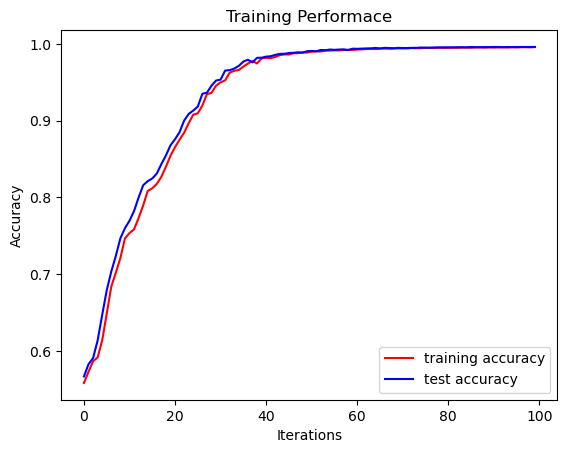

In [32]:
plot_accuracy_performance(train_accs, val_accs)

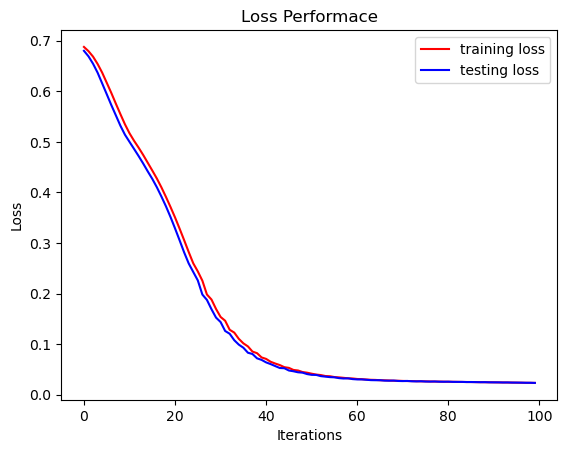

In [33]:
plot_loss_performance(train_losses, val_losses)